ロボット制御プログラミング
障害物を回避しながら得点を増やしていく動的制御プログラミング法

ライブラリのインポート

In [23]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np
from scipy.stats import multivariate_normal
import random 
import copy

xmax = 10
xmin = 0
hmax = 70
hmin = 30

画面に表示する世界の状態を表すクラス

In [24]:
class World:
    def __init__(self, time_span, time_interval, debug=True):
        self.objects = []  
        self.debug = debug
        self.time_span = time_span  
        self.time_interval = time_interval
        self.score = 0
        self.puddles = []
        self.robots = []
        self.goals = []
        
    #要素を追加する関数
    def append(self,obj):  
        self.objects.append(obj)
        #ロボットとゴールは、別に認識
        if isinstance(obj, Robot): self.robots.append(obj)
        if isinstance(obj, Goal): self.goals.append(obj)
    
    #描画関数
    def draw(self):
        #描画設定
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')             
        ax.set_xlim(xmin,xmax)                  
        ax.set_ylim(xmin,xmax) 
        ax.set_xlabel("X",fontsize=10)                 
        ax.set_ylabel("Y",fontsize=10)                 
        
        #描画要素のリスト
        elems = []
        
        #描画実行（デバッグ用に分岐あり）
        if self.debug:        
            for i in range(int(self.time_span/self.time_interval)): self.one_step(i, elems, ax)
        else:
            self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax),
                                     frames=int(self.time_span/self.time_interval)+1, interval=int(self.time_interval*1000), repeat=False)
            plt.show()
    
    #状態を更新する関数
    def one_step(self, i, elems, ax):
        while elems: elems.pop().remove()
        #時間を進める
        time_str = "time %.2f[s]" % (self.time_span - (self.time_interval*i))
        elems.append(ax.text(xmin + 0.2, xmax - 0.4, time_str, fontsize=10))
        score_str = "score = %.2f" % self.score
        elems.append(ax.text(xmin + 0.2, xmax - 0.7, score_str, fontsize=10))
        #状態更新
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"): obj.one_step(self.time_interval)
        #ゴール判定
        for r in self.robots:
            for g in self.goals:
                    if g.inside(r.pose):
                        self.score = self.score + int(g.height)
                        g.replace()

ゴールのクラス

In [25]:
class Goal: 
    def __init__(self, x, y, height,radius=0.5):
        self.pos = np.array([x, y]).T
        self.radius = radius
        self.height = height
        self.count1 = 0
        self.count2 = 0
    
    #判定
    def inside(self, pose): 
        return self.radius > math.sqrt( (self.pos[0]-pose[0])**2 + (self.pos[1]-pose[1])**2 )
    
    def chenge_peak(self, hs = 7):
        r = np.random.rand(2) -0.5
        self.pos = self.pos + r
        self.pos[self.pos > xmax] = (np.random.rand()* 6 + 2)
        self.pos[self.pos < xmin] = (np.random.rand()* 6 + 2)
        
        delta = np.random.randn()
        self.height = self.height + (hs * delta)
        if self.height > hmax:
            self.height = (2 * hmax) - self.height
        elif self.height < hmin:
            self.height = (2 * hmin) - self.height
    
    def fuzzy(self):
        r = np.random.rand()*6-3
        self.height = self.height + r
        if self.height > hmax:
            self.height = (2 * hmax) - self.height
        elif self.height < hmin:
            self.height = (2 * hmin) - self.height
    
    def replace(self):
        self.pos = (xmax - xmin) * (np.random.rand(2) * 0.9) + (xmin + 1)
        self.height = (hmax - hmin) * np.random.rand() + hmin
    
    #描画
    def draw(self, ax, elems):
        x, y = self.pos
        c = ax.scatter(x, y, s=240, marker=".", label="landmarks", color="green")
        elems.append(c)
        elems.append(ax.text(self.pos[0] + 0.1, self.pos[1] + 0.1, str(int(self.height)), fontsize=10))
        
    def one_step(self, time_interval):
        self.count1 += time_interval
        self.count2 += time_interval
        if self.count1 > 5.0:
            self.chenge_peak()
            self.count1 = 0
            
        if self.count2 > 1.0:
            self.fuzzy()
            self.count2 = 0

ロボット本体のクラス

In [26]:
class Robot:   
    def __init__(self, pose, agent=None, color="black"):   
        self.pose = pose
        self.r = 0.2  
        self.color = color 
        self.agent = agent
        self.poses = [pose]
    
    #描画
    def draw(self, ax, elems): 
        x, y, theta = self.pose  
        xn = x + self.r * math.cos(theta)  
        yn = y + self.r * math.sin(theta)  
        elems += ax.plot([x,xn], [y,yn], color=self.color)
        c = patches.Circle(xy=(x, y), radius=self.r, fill=False, color=self.color) 
        elems.append(ax.add_patch(c))
        self.poses.append(self.pose)
        #elems += ax.plot([e[0] for e in self.poses], [e[1] for e in self.poses], linewidth=0.5, color="black")
        if self.agent and hasattr(self.agent, "draw"):                       
            self.agent.draw(ax, elems)
    
    #本体を進める関数
    @classmethod           
    def state_transition(cls, nu, omega, time, pose):
        t0 = pose[2]
        #回転速度の違いで分岐
        if math.fabs(omega) < 1e-10:
            return pose + np.array( [nu*math.cos(t0), 
                                     nu*math.sin(t0),
                                     omega ] ) * time
        else:
            return pose + np.array( [nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)), 
                                     nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                                     omega*time ] )
    #状態更新する関数
    def one_step(self, time_interval):
        if not self.agent: return        
        nu, omega = self.agent.decision()
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        self.agent.pose = self.pose 

群を成す粒子のクラス

In [27]:
class Particle: 
    def __init__(self, pos, weight):
        self.pos = pos
        self.weight = weight
        self.d = (xmax - xmin) / 2
        self.local = 1
            

群全体のクラス

In [28]:
class group:  
    def __init__(self, envmap, goal, obstacle = 20, delta = 1.1, cd = 0.1, nl = 4):
        self.particles = []
        self.map = envmap
        self.goals = goal
        self.count = 0
        self.bees = 0
        self.obstacle = obstacle
        self.delta = delta
        self.cd = cd
        self.nl = nl
    
    #粒子を追加する関数
    def append_particles(self, num):
        self.bees = num
        for i in range(num):
            #初期値設定
            pos = (xmax - xmin) * np.random.rand(2) + xmin
            weight = -100
            for g in self.goals:
                diff = pos - g.pos
                a = g.height - np.hypot(*diff)
                if weight < a:
                    weight = a
            for lm in self.map.obstacles:
                diff = position - lm.pos
                weight = weight - (self.obstacle / (1 + np.hypot(*diff)))
            self.particles.append(Particle(pos, weight))
        #最良の個体を決定する
        self.set_best()
        
    #最良の個体を設定する関数
    def set_best(self):
        i = np.argmax([p.weight for p in self.particles])
        self.best = self.particles[i]
        self.pos = self.best.pos
    
    #1範囲内に粒子を戻す関数
    def x_check(self,a):
        if a > xmax:
            a = (2 * xmax) - a
        elif a < xmin:
            a = (2 * xmin) - a

        return a
    
    # ルーレット選択用関数
    def roulette_choice(self, w):
        t = np.cumsum(w)
        r = np.random.random() * np.sum(w)  #0∼1の乱数*重みの累積和（最大値が累積和になるようにするため）
        for i, e in enumerate(t):   #インデックスと値をenumurateで取得できる間ずっと代入し続ける
            if r < e:
                return i    #累積和が乱数より大きい場合iを返す
    
    #各粒子を移動させる関数(ALIS ABCアルゴリズム)
    def motion_update(self, time, robo_pose): 
        
        #収穫蜂フェーズ
        for i,p in enumerate(self.particles): 
            k = i
            while k == i:
                k = np.random.randint(self.bees)
            v = p.pos.copy()
            r = np.random.rand()*2-1 #-1から1までの一様乱数
            j = np.random.randint(2) #変更する次元
            diff = np.sqrt(np.sum((p.pos - self.particles[k].pos)**2))
            if diff < p.d:
                v[j] = p.pos[j] + r * (p.pos[j] - self.particles[k].pos[j]) #近傍点計算
            else:
                v[j] = p.pos[j] + (r * p.d)
            v[j] = self.x_check(v[j])
            
            if self.func(p.pos, robo_pose) < self.func(v, robo_pose):
                p.pos = v
        
        #追従蜂フェーズ
        for i,p in enumerate(self.particles):
            v = p.pos.copy()
            w = []
            for j in range(self.bees):
                w.append(self.func(self.particles[j].pos, robo_pose))
            l = self.roulette_choice(w)
            k = l
            while k == l:
                k = np.random.randint(self.bees)

            r = np.random.rand()*2-1 #-1から1までの一様乱数
            j = np.random.randint(2) #変更する次元
            diff = np.sqrt(np.sum((p.pos - self.particles[k].pos)**2))
            if diff < p.d:
                v[j] = p.pos[j] + r * (p.pos[j] - self.particles[k].pos[j]) #近傍点計算
            else:
                v[j] = p.pos[j] + (r * p.d)
            v[j] = self.x_check(v[j])
            
            if self.func(p.pos, robo_pose) < self.func(v, robo_pose):
                p.pos = v
        
        #偵察蜂フェーズ
        for i,p in enumerate(self.particles):
            p.local = 1
            for j in range(self.bees):
                diff = np.sqrt(np.sum((p.pos - self.particles[j].pos)**2))
                if diff < p.d:
                    if self.func(p.pos, robo_pose) < self.func(self.particles[j].pos, robo_pose):
                        p.local += 1

            rate = 1 / (1 + np.exp(2 * (self.nl - p.local)))
            r = np.random.rand()
            if rate > r:
                p.pos = (xmax-xmin)*np.random.rand(2) + xmin
                p.d = (xmax - xmin) / 2
                p.local = 1

        #更新（初期化確率及び移動範囲）
        for i,p in enumerate(self.particles):
            if p.local == 1:
                flug = True
                add = False
                for j in range(self.bees):
                    diff = np.sqrt(np.sum((p.pos - self.particles[j].pos)**2))
                    if diff < p.d:
                        p.d = p.d - self.delta
                        flug = False
                    elif diff < (p.d + self.delta):
                        add = True
                if flug and add:
                    p.d = p.d + self.delta
            else:
                flug = True
                for j in range(self.bees):
                    diff = np.sqrt(np.sum((p.pos - self.particles[j].pos)**2))
                    if diff < self.cd:
                        if p.local == 1:
                            p.d = self.particles[j].d
                            flug = False
                if flug:
                    p.d += p.d + self.delta
            
    
    def func(self, position, robo_pose):
        #ゴールとの距離を評価とする
        weight = -100
        for g in self.goals:
            diff = position - g.pos
            a = g.height - np.hypot(*diff)
            if weight < a:
                weight = a
        #障害物と近いほど減点
        for i,lm in enumerate(self.map.obstacles):
            diff = position - lm.pos
            if i == 0:
                denger = self.obstacle / (1 + np.hypot(*diff))
            a = self.obstacle / (1 + np.hypot(*diff))
            if denger < a:
                denger = a
        weight -= denger
        #移動コストを追加
        cost = position - robo_pose[:2]
        weight = weight - (np.hypot(*cost) * 0.5)
        
        return weight
    
    #各粒子の評価値更新
    def observation_update(self, robo_pose): 
        for p in self.particles:
            p.weight = self.func(p.pos, robo_pose)
        self.set_best()
        dis = self.pos[:2] - robo_pose[:2]
        if np.hypot(*dis) < 0.5:
            self.count = self.count + 1
            if self.count> 10:
                self.particles = []
                self.append_particles(50)
                self.count = 0
        else:
            self.count = 0
        
    #描画
    def draw(self, ax, elems):  
        c = ax.scatter(self.best.pos[0], self.best.pos[1], s=120, marker=".", color="blue")
        elems.append(c)

ロボットの目標を定める関数

In [29]:
class Agent(): 
    def __init__(self, pose, time_interval, estimator, goal, sensor = None):
        self.nu = 0
        self.omega = 0
        self.pose = pose
        self.estimator = estimator
        self.time_interval = time_interval
        self.sensor = sensor
        
        self.prev_nu = 0
        self.prev_omega = 0
        self.goal = goal
    
    #目標に向かう関数
    @classmethod   
    def policy(cls, pose, goal):
        x, y, theta = pose
        dx, dy = goal.pos[0] - x, goal.pos[1] - y
        direction = int((math.atan2(dy, dx) - theta)*180/math.pi)   #ゴールの方角（degreeに直す）
        direction = (direction + 360*1000 + 180)%360 - 180      #方角を-180〜180[deg]に正規化（適当。ロボットが-1000回転すると破綻）
        
        if (direction < 20) and (direction > -20): nu, omega = 4.0, 0.0
        elif direction > 0: nu, omega = 0.0, 4.0
        else: nu, omega = 0.0, -4.0
            
        return nu, omega
    
    #速度決定関数
    def decision(self): 
        #群れを更新する
        self.estimator.motion_update(self.time_interval, self.pose)
        self.estimator.observation_update(self.pose)
        #目標を定める
        nu, omega = self.policy(self.pose, self.estimator)
        #障害物回避関数
        observe = self.sensor.data(self.pose)
        if observe:
            nu, omega = self.policy(self.pose, observe[0][0])
            nu = -nu
            if omega != 0:
                omega = -omega
                nu = 4.0
        self.prev_nu, self.prev_omega = nu, omega
        
        return nu, omega
   
    #描画
    def draw(self, ax, elems): 
        self.estimator.draw(ax, elems)
        x, y = self.estimator.pos 

障害物のクラス

In [30]:
class Obstacle:
    def __init__(self, x, y):
        self.pos = np.array([x, y]).T
        self.id = None
    
    #移動関数（回転方向に運動する）
    def motion_update(self, time_interval):
        omega = time_interval / 32
        x, y = self.pos
        dx, dy = 5 - x, 5 - y
        direction = math.atan2(dy, dx)
        radian = (math.pi * omega) + direction
        if radian > (2 * math.pi):
            radian -= (2 * math.pi)
        self.pos = np.array([5,5]) + np.array( [4 * np.cos(radian),4 * np.sin(radian)] )
        
    #描画
    def draw(self, ax, elems):
        x, y = self.pos
        c = ax.scatter(self.pos[0], self.pos[1], s=120, marker=".", label="landmarks", color="red")
        elems.append(c)
        c = ax.scatter(x + 0.2, y, s=40, marker=">", label="landmarks", color="red")
        elems.append(c)
        c = ax.scatter(x - 0.2, y, s=40, marker="<", label="landmarks", color="red")
        elems.append(c)
        c = ax.scatter(x, y + 0.2, s=40, marker="^", label="landmarks", color="red")
        elems.append(c)
        c = ax.scatter(x, y - 0.2, s=40, marker="v", label="landmarks", color="red")
        elems.append(c)

障害物を管理するクラス

In [31]:
class Map:
    def __init__(self):       # 空のランドマークのリストを準備
        self.obstacles = []
        
    def append_obstacle(self, obstacle):       # ランドマークを追加
        obstacle.id = len(self.obstacles)           # 追加するランドマークにIDを与える
        self.obstacles.append(obstacle)
        
    def one_step(self, time_interval):
        for lm in self.obstacles: lm.motion_update(time_interval)

    def draw(self, ax, elems):                 # 描画
        for lm in self.obstacles: lm.draw(ax, elems)

センサーのクラス

In [32]:
class Camera:
    def __init__(self, env_map, \
                 distance_range=(0, 1),
                 direction_range=(-math.pi/ 3, math.pi/3)):
        self.map = env_map
        self.lastdata = []
        self.distance_range = distance_range
        self.direction_range = direction_range
    
    #見える判定の関数
    def visible(self, polarpos):  
        if polarpos is None:
            return False
        
        return self.distance_range[0] <= polarpos[0] <= self.distance_range[1] \
                and self.direction_range[0] <= polarpos[1] <= self.direction_range[1]
    
    #見えたデータを作成する関数
    def data(self, cam_pose):
        observed = []
        for lm in self.map.obstacles:
            z = self.observation_function(cam_pose, lm.pos)
            if self.visible(z):               # 条件を追加
                observed.append((lm, lm.id))   # インデント
            
        self.lastdata = observed 
        return observed
    
    #距離と方向を算出する関数
    @classmethod
    def observation_function(cls, cam_pose, obj_pos):
        diff = obj_pos - cam_pose[0:2]
        phi = math.atan2(diff[1], diff[0]) - cam_pose[2]
        while phi >= np.pi: phi -= 2*np.pi
        while phi < -np.pi: phi += 2*np.pi
        return np.array( [np.hypot(*diff), phi ] ).T
    
    #描画
    def draw(self, ax, elems, cam_pose): 
        for lm in self.lastdata:
            x, y, theta = cam_pose
            distance, direction = lm[0][0], lm[0][1]
            lx = x + distance * math.cos(direction + theta)
            ly = y + distance * math.sin(direction + theta)
            elems += ax.plot([x,lx], [y,ly], color="pink")

<IPython.core.display.Javascript object>


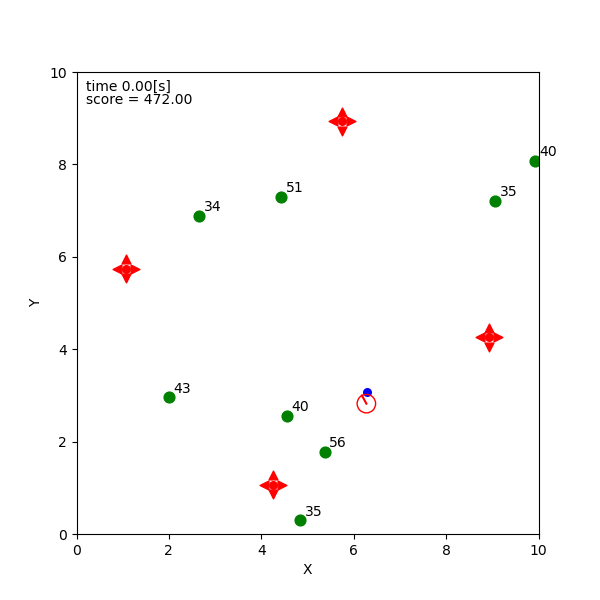

In [33]:
if __name__ == '__main__':   ###name_indent
    
    time_interval = 0.1
    world = World(30, time_interval, debug=False) 

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()
    obs_posi =[[2,5],[8,5],[5,2],[5,8]] 
    for p in obs_posi:
        m.append_obstacle(Obstacle(p[0],p[1]))
    world.append(m)      
    
    ##ゴールの追加##
    for i in range(8):
        position = (xmax - xmin) * (np.random.rand(2) * 0.9) + (xmin + 1)
        height = (hmax - hmin) * np.random.rand() + hmin
        goal = Goal(position[0],position[1],height)  #goalを変数に
        world.append(goal) 

    ### ロボットを作る ###
    initial_pose = np.array([xmin + 0.5, xmin + 0.5, 0]).T
    group = group(m, world.goals)
    group.append_particles(50)
    a = Agent(initial_pose, time_interval, group, goal,sensor = Camera(m))
    r = Robot(initial_pose, agent=a, color="red")
    world.append(r)

    ### アニメーション実行 ###
    world.draw()